In [1]:
%%capture
%load_ext autoreload
%autoreload 2

import seaborn as sns
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from numpy.random import default_rng

import zipfile
from src.data.datasets import (
    SiteDataset, FloorDataset, TraceData, raw_path, RAW_FILE_NAME
)

sns.set_style("whitegrid")
sns.set_context("notebook");

# Introduction

In this project, we look at the data from the ["Indoor Location & Navigation" Kaggle competition](https://www.kaggle.com/c/indoor-location-navigation). The stated goal of this Kaggle competetion is to be able to accurately predict a phones position based on various sensor readings including WIFI and iBeacon signals, and accerometer and gyroscope readings. The data is collected across 200+ shopping malls in China, and consists of a collection of trace files from various phones, logging various sensor data and ground truth waypoints. 


# The trace files
The trace files are organized with respect to a `site_id`, a `floor_id` and a `trace_id`. An example trace file is defined below: 

In [2]:
site_id = "5a0546857ecc773753327266"
floor_id = "B1"
trace_id = "5e15bf91f4c3420006d52341"

Since the unzipped data is quite large, using about 58 GB of storage, the raw data is left zipped, only requiring about 13 GB storage. Single trace files can then be pulled out using the `zipfile` module. Below, the first twenty lines of the tracefile defined above can be seen 

In [3]:
with zipfile.ZipFile(raw_path / RAW_FILE_NAME) as zip_file:
    trace_file = zipfile.Path(zip_file) / "train" / site_id / floor_id / f"{trace_id}.txt"
    with trace_file.open() as f:
        for i in range(20):
            print(next(f).strip())

#	startTime:1578483534743
#	SiteID:5a0546857ecc773753327266	SiteName:西溪银泰城	FloorId:5a24ae78fe4e220014739c5c	FloorName:地下一层
#	Brand:OPPO	Model:PBCM10	AndroidName:8.1.0	APILevel:27
#	type:1	name:BMI160 Accelerometer	version:2062600	vendor:BOSCH	resolution:0.0023956299	power:0.18	maximumRange:39.22661
#	type:4	name:BMI160 Gyroscope	version:2062600	vendor:BOSCH	resolution:0.0010681152	power:0.9	maximumRange:34.906586
#	type:2	name:AK09911 Magnetometer	version:1	vendor:AKM	resolution:0.5996704	power:2.4	maximumRange:4911.9995
#	type:35	name:BMI160 Accelerometer Uncalibrated	version:2062600	vendor:BOSCH	resolution:0.0023956299	power:0.18	maximumRange:39.22661
#	type:16	name:BMI160 Gyroscope Uncalibrated	version:2062600	vendor:BOSCH	resolution:0.0010681152	power:0.9	maximumRange:34.906586
#	type:14	name:AK09911 Magnetometer Uncalibrated	version:1	vendor:AKM	resolution:0.5996704	power:2.4	maximumRange:4911.9995
#	VersionName:v20191120-nightly-9-gde3748b	VersionCode:424
1578483534752	TYPE_WAYPO

In order to use this data, the records are organized with respect to the second column. The field data types and names for each `TYPE` is determined, and a `pandas` dataframe is used to hold the records of each `TYPE`. All of this is done in the `src/data/extract_data.py` script and encapsulated in the `TraceData` class.

In [4]:
trace_data = TraceData(site_id, floor_id, trace_id)
trace_data.data["TYPE_ACCELEROMETER"]

,x,y,z,accuracy
time,,,,
0 days 00:00:00.111000,-2.782318,1.700607,9.319611,2
0 days 00:00:00.131000,-2.868515,1.725754,9.208878,2
0 days 00:00:00.151000,-2.969070,1.614426,9.480621,2
0 days 00:00:00.171000,-2.911606,1.612625,9.602127,2
0 days 00:00:00.191000,-2.856537,1.543793,9.489593,2
...,...,...,...,...
0 days 00:00:45.477000,-0.706543,4.733475,7.746017,2
0 days 00:00:45.497000,-0.640701,4.553299,9.887634,2
0 days 00:00:45.518000,-0.769989,4.963318,10.821976,2


Now that we have organized the data, we can plot the data. Below a plot of the path of the trace is shown.

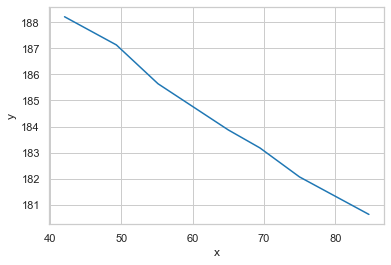

In [5]:
sns.lineplot(data=trace_data.data["TYPE_WAYPOINT"], x="x", y="y", sort=False);

Since we are also provided images of each floor, we may provide some context to the path above:

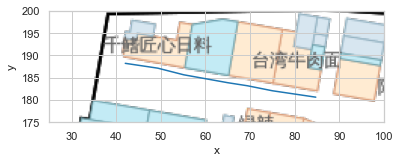

In [6]:
floor_data = FloorDataset(site_id, floor_id)
floor_image = floor_data.image
floor_height = floor_data.info["map_info"]["height"]
floor_width = floor_data.info["map_info"]["width"]

plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height))
sns.lineplot(data=trace_data.data["TYPE_WAYPOINT"], x="x", y="y", sort=False)
plt.xlim((25, 100))
plt.ylim((175, 200));


So the trace consists of a path down a corridor. The various sensor readings down this path can also be plotted. For instance, the iBeacon protocol allows for estimation of the distance from the phone to the different beacons. This estimate is provided to us in the log files, and can be seen below.  

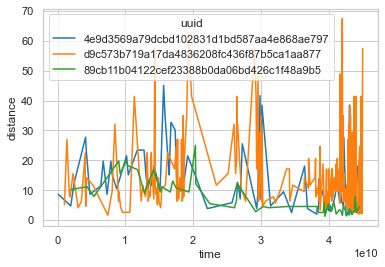

In [7]:
sns.lineplot(data=trace_data.data["TYPE_BEACON"], x="time", y="distance", hue="uuid");

As we can see, there are not that many different beacons in the data, and the estimates are quite noisy. However they may still be somewhat usesful, particularily if we are able to account for the additional variance. These estimates are a relatively straight-forward function of the signal strength:

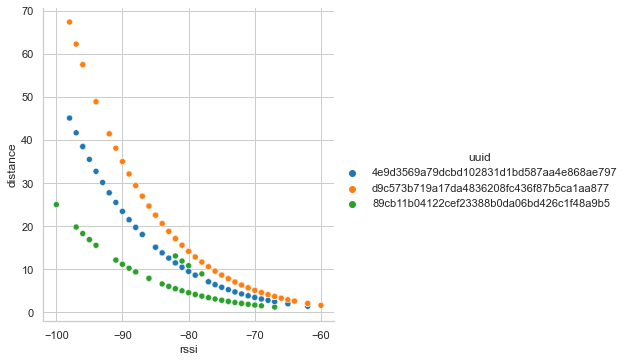

In [8]:
sns.relplot(data=trace_data.data["TYPE_BEACON"], x="rssi", y="distance", hue="uuid");

There are quite a bit more different WiFi signals logged in the trace file:

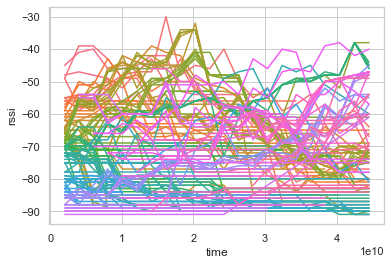

In [9]:
sns.lineplot(
    data=trace_data.data["TYPE_WIFI"], x="time", y="rssi", hue="bssid", legend=None
);


Since these do not include a distance estimate, we will have to model the signal strength of the WiFi ourselves in order to relate it to the position of the trace.

Finally, we can take a look at the different physical sensor readings.



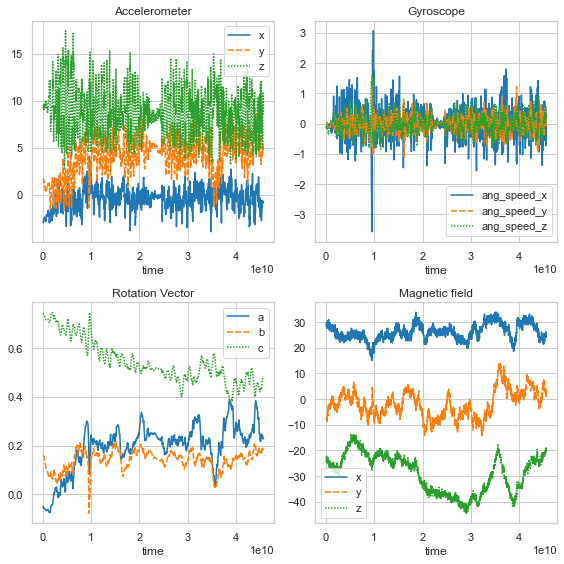

In [10]:
fig, _ = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))
sns.lineplot(
    data=trace_data.data["TYPE_ACCELEROMETER"][["x", "y", "z"]], ax=fig.axes[0]
)
sns.lineplot(
    data=trace_data.data["TYPE_GYROSCOPE"][
        ["ang_speed_x", "ang_speed_y", "ang_speed_z"]
    ],
    ax=fig.axes[1],
)
sns.lineplot(
    data=trace_data.data["TYPE_ROTATION_VECTOR"][["a", "b", "c"]], ax=fig.axes[2]
)
sns.lineplot(
    data=trace_data.data["TYPE_MAGNETIC_FIELD"][["x", "y", "z"]], ax=fig.axes[3]
)
fig.axes[0].set_title("Accelerometer")
fig.axes[1].set_title("Gyroscope")
fig.axes[2].set_title("Rotation Vector")
fig.axes[3].set_title("Magnetic field")
plt.tight_layout()


These are sampled quite a bit more frequently than the other values. We also think it would be interesting if we could relate these readings somehow to the physical states of the trace - position, velocity and acceleration. 

# Floor data

As mentioned above, we are also provided images of each floor. Below, an image of the entire floor can be seen:

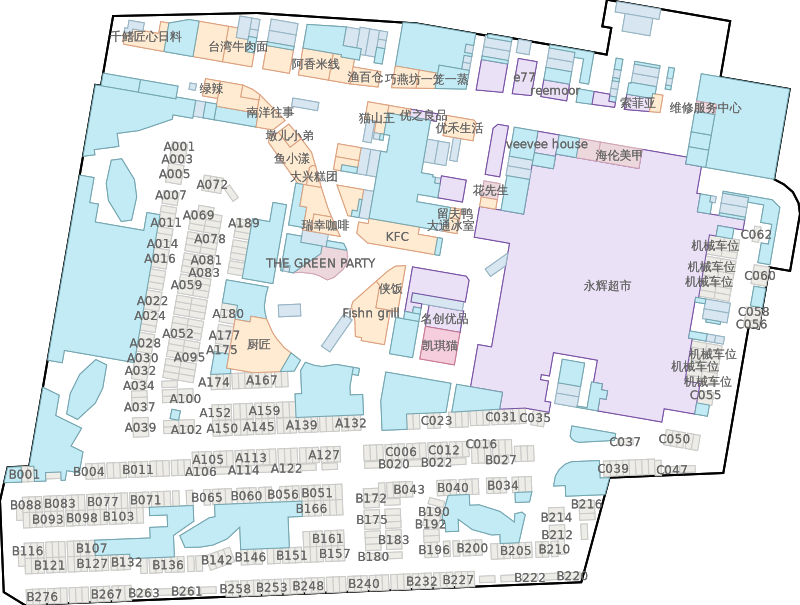

In [11]:
floor_image

We may also investigate how the different traces are distributed across the floor, by combining the waypoint information for every trace on the floor.

In [12]:
floor_data.extract_traces()
traces = floor_data.traces
combined_waypoints = pd.concat(
    [t_data.data["TYPE_WAYPOINT"] for t_data in traces],
    keys = [t_data.trace_id for t_data in traces],
    names=["trace_id"]
)

100%|██████████| 109/109 [00:00<00:00, 121.98it/s]


In [13]:
plot_order = default_rng(42).permutation(
    combined_waypoints.index.get_level_values(0).unique(),
)


<AxesSubplot:xlabel='x', ylabel='y'>

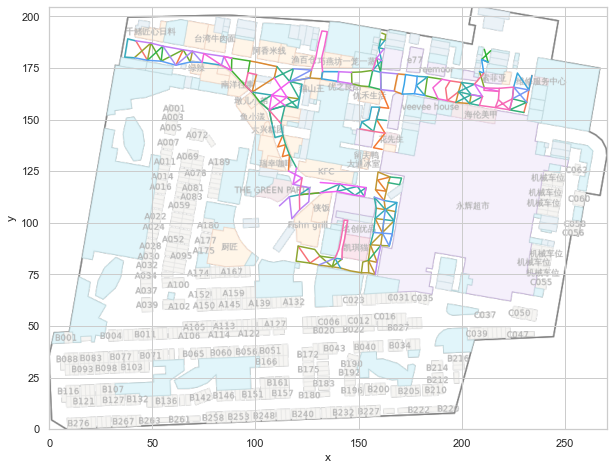

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(floor_data.image, extent=(0, floor_width, 0, floor_height), alpha=0.5)
sns.lineplot(data=combined_waypoints.loc[plot_order], x="x", y="y", sort=False, hue="trace_id", legend=False)


## WiFi signals
The minimum requirement for getting a location using triangulation is 3 signals. It is seen in the figure below that each trace(cell phone) recives signals from more than 50 routers at all times. Therefore, doing triangulation using WIFI signals might be very feasible.



In [15]:
combined_WIFI = pd.concat(
    [t_data.data["TYPE_WIFI"] for t_data in traces],
    keys = [t_data.trace_id for t_data in traces],
    names=["trace_id"]
)
combined_WIFI["trace_ID"] = combined_WIFI.index.get_level_values('trace_id')

In [16]:
def f(x):
    return pd.Series({"# WIFI routers": x["bssid"].count()})

Average number of bssids/routers for a trace: 167.85


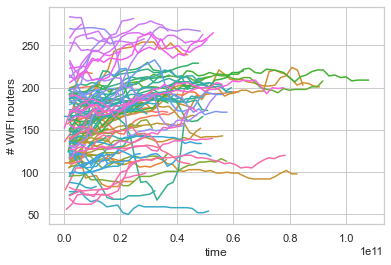

In [17]:
B = combined_WIFI.groupby(['trace_id','time']).apply(f)
sns.lineplot(data=B, x ="time", y="# WIFI routers", hue="trace_id", legend=False);
print(f"Average number of bssids/routers for a trace: {B['# WIFI routers'].mean():.2f}")

## Enough data for inference?
How much does each of the 1374 WIFI routers on the floor B2 communicate with the traces B2? I.e. how much data is available for the likelihood (and posterior) of the recived signal/rssi $w_{t,k}$ for $k = 1,\dots, \# routers$? 

In [18]:
def f2(x):
    return pd.Series({"# recived signals": x["rssi"].count(),
                    "Unique traces": x["trace_ID"].nunique()})

Total number of WIFI routers: 1374
Number of WIFI routers below 20 signals: 275


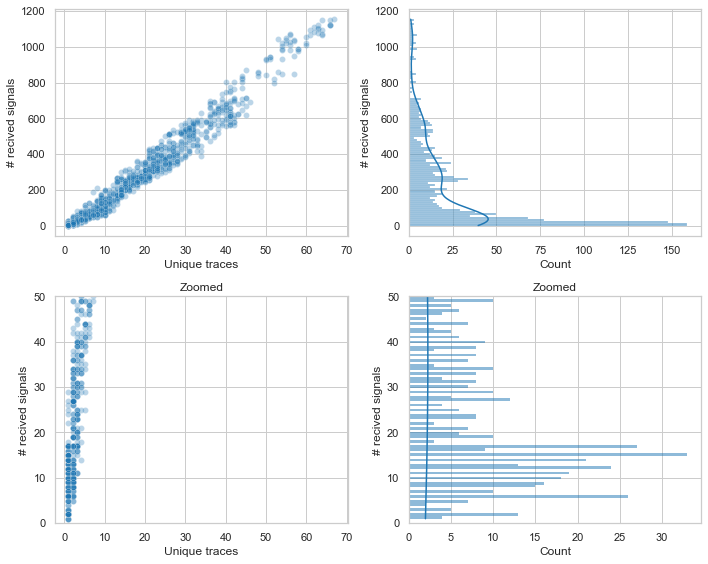

In [19]:
A = combined_WIFI.groupby(["bssid"]).apply(f2)

fig, _ = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))

sns.scatterplot(data=A, y = "# recived signals", x = "Unique traces", alpha=0.3, ax=fig.axes[0])
sns.histplot(data=A, y="# recived signals", kde=True,  ax=fig.axes[1], bins=100)

sns.scatterplot(data=A, y = "# recived signals", x = "Unique traces", alpha=0.3, ax=fig.axes[2])
sns.histplot(data=A, y="# recived signals", kde=True,  ax=fig.axes[3],bins=100*20)
fig.axes[2].set(ylim=(0,50))
fig.axes[3].set(ylim=(0,50))

fig.axes[2].set_title("Zoomed")
fig.axes[3].set_title("Zoomed")
plt.tight_layout()

print(f"Total number of WIFI routers: {len(A)}")
print(f"Number of WIFI routers below 20 signals: {sum(A['# recived signals']<20)}")


So we see for this specific floor there will be different amount of data available to define the posteriors of $w_{t,k}$ i.e. some posteriers will be more informative than others

### Communication between floors? 

In this notebook we only look at a specific floor (B1), however, there are more floors and WiFi might also be able to travel through floors. This might provide more data for the floors and give more informative posteriers. 

## Interpolation of coordinates and WIFI signal
Combining time records of real coordinates (WayPoint) with time records of recieved signals for each WIFI router. This is done in order to linerly interpolate the coordinates for the location where a phone recived a signal. The coordinates are plotted on a map weighted with the signal strengths (rssi values). This gives the observed signal strength for each WiFi router at different location across the floor. We by then plot the observed signal strength for some randomly chosen routers:

In [20]:
n_bssids = 4
bssids = default_rng(10).choice(
    traces[0].data["TYPE_WIFI"]["bssid"].unique(), n_bssids,)

In [21]:
wifi_strengths = {
    "x" : [],
    "y" : [],
    "rssi" : [],
    "bssid" : [],
}

for trace in tqdm(traces):
    for bssid, wifi_data in trace.data["TYPE_WIFI"].groupby("bssid"):

        if bssid not in bssids:
            continue
        interpolated_wifi = pd.DataFrame(
            {
                "x": trace.data["TYPE_WAYPOINT"]["x"],
                "y": trace.data["TYPE_WAYPOINT"]["y"],
                "rssi": wifi_data["rssi"].groupby("time").mean(),
            }
        ).interpolate("time").bfill().reindex(trace.data["TYPE_WAYPOINT"].index)

        wifi_strengths["x"].extend(interpolated_wifi["x"])
        wifi_strengths["y"].extend(interpolated_wifi["y"])
        wifi_strengths["rssi"].extend(interpolated_wifi["rssi"])
        wifi_strengths["bssid"].extend(len(interpolated_wifi)*[bssid])

wifi_strengths_df = pd.DataFrame(wifi_strengths)

100%|██████████| 109/109 [00:01<00:00, 68.56it/s]


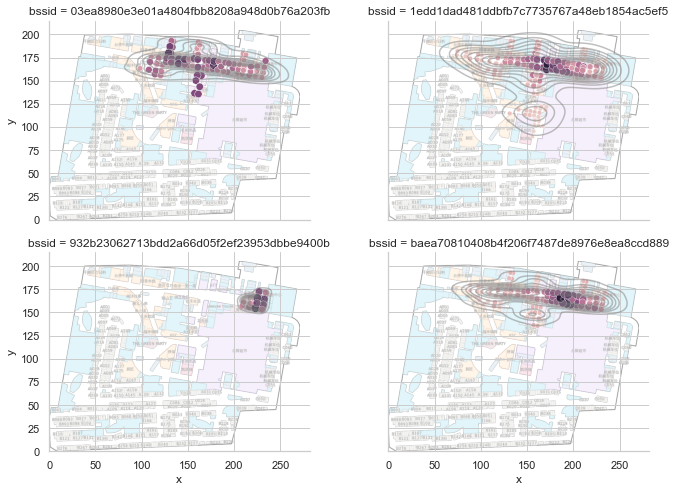

In [22]:
def weighted_kde(x, y, weights, **kwargs):
    plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.5)
    sns.kdeplot(x=x, y=y, weights=weights, color="grey", alpha=0.5)
    sns.scatterplot(x=x, y=y, size=weights, hue=weights, s=20, **kwargs)

g = sns.FacetGrid(data=wifi_strengths_df, col="bssid", col_wrap=2, height=3.5, aspect=1.5)
g.map(weighted_kde, "x", "y", "rssi")